In [2]:
#need pip install spotipy to run this
import json
import spotipy
import csv
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import base64
import itertools
import seaborn as sns
import scipy.stats as stats
from scipy.stats import ttest_ind
from requests import post, get
from config import cid, secret

In [3]:
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [4]:
results = sp.search(q='artist:' + 'Drake', type='artist')

In [5]:
auth_string = cid + ":" + secret
auth_bytes = auth_string.encode('utf-8')
auth_base64 = str(base64.b64encode(auth_bytes), 'utf-8')
url = "https://accounts.spotify.com/api/token"
headers = {
    'Authorization': 'Basic ' + auth_base64,
    'Content-Type': 'application/x-www-form-urlencoded'
}
data = {"grant_type": "client_credentials"}
result = post(url, headers=headers, data=data)
json_result = json.loads(result.content)
token = json_result['access_token']
print(token)

BQBFBjKqEd2gYQ41MvV50yxktIAEF-_S7OKerJxZeW81iMd4_ZzC2l0dPhD726TmULu-njD46HJ7_tWBi8vXDoIxUQujQlYZpJ9oY3WELrYyornzehax


In [6]:
playlist_link = "https://open.spotify.com/playlist/37i9dQZF1DX7Jl5KP2eZaS?si=fa88101bc2b04d96"
playlist_URI = playlist_link.split("/")[-1].split("?")[0]
track_uris = [x["track"]["uri"] for x in sp.playlist_tracks(playlist_URI)["items"]]

In [7]:
sp.playlist_tracks(playlist_URI)['items'][0]['track']['duration_ms']

200040

In [8]:
genres = ''
song_name = []
artist_name = []
artist_pop = []
genre_list = []
album = []
track_pop = []
years = []
links = []
song_years = []
song_duration = []
genres_compiled = []
counts = []
#playlist_df = pd.read_csv('Resources/Playlistlinks.csv')
with open('Resources/Playlistlinks.csv') as file_obj:
    reader_obj = csv.reader(file_obj)
    next(reader_obj)
    for row in reader_obj:
        years.append(row[0])
        links.append(row[1])
for (link, year) in zip(links, years):
    #URI
    playlist_link = link
    playlist_URI = playlist_link.split("/")[-1].split("?")[0]
    #track_uris = [x["track"]["uri"] for x in sp.playlist_tracks(playlist_URI)["items"]]
    print(f"Starting link {link}")
    count = 1
    for track in sp.playlist_tracks(playlist_URI)["items"]:
        if count == 51:
            break
        track_uri = track["track"]["uri"]
        #print(track_uri)
        #track = sp.track(track_uri)
        #print(track)
        #break
        song_genre = sp.track(track_uri)
        #print(song_genre['genre'])

        #Track name
        song_name.append(track["track"]["name"])

        #Main Artist
        artist_uri = track["track"]["artists"][0]["uri"]
        #print(f"Uri:{artist_uri}")
        artist_info = sp.artist(artist_uri)

        #Name, popularity, genre
        artist_name.append(track["track"]["artists"][0]["name"])
        artist_pop.append(artist_info["popularity"])
        artist_genres = artist_info["genres"]
        for genre in artist_genres:
            if genre == artist_genres[-1]:
                genres = genres + genre + ' '
            else: 
                genres = genres + genre + ', '
        genre_list.append(genres)
        genres = ''
        #Album
        album.append(track["track"]["album"]["name"])

        song_duration.append((track['track']['duration_ms']) / 60000)

        song_years.append(year)
    
        #Popularity of the track
        track_pop.append(track["track"]["popularity"])
        counts.append(count)
        count += 1
    
print(f"Song name count: {len(song_name)}")
print(f"Artist name count:{len(artist_name)}")
print(f"Artist pop count:{len(artist_pop)}")
print(f"Artist genre count:{len(genre_list)}")
print(f"Artist album count:{len(album)}")
print(f"Track pop count:{len(track_pop)}")
print(f"Artist name count:{len(song_years)}")
print(f"Position in top 50 count:{len(counts)}")

Starting link https://open.spotify.com/playlist/37i9dQZF1DX8XZ6AUo9R4R?si=3c0783980c4845f7
Starting link https://open.spotify.com/playlist/37i9dQZF1DWTE7dVUebpUW?si=0e58db4c553a43c9
Starting link https://open.spotify.com/playlist/37i9dQZF1DXe2bobNYDtW8?si=3b770ab0d4214b13
Starting link https://open.spotify.com/playlist/37i9dQZF1DWVRSukIED0e9?si=08712985b70e4e0d
Starting link https://open.spotify.com/playlist/37i9dQZF1DX7Jl5KP2eZaS?si=d2cd57cf194b48cb
Starting link https://open.spotify.com/playlist/37i9dQZF1DXbJMiQ53rTyJ
Starting link https://open.spotify.com/playlist/37i9dQZF1DXcBWIGoYBM5M
Song name count: 350
Artist name count:350
Artist pop count:350
Artist genre count:350
Artist album count:350
Track pop count:350
Artist name count:350
Position in top 50 count:350


In [9]:
top_songs_df = pd.DataFrame({"Year": song_years,
                            "Song Name": song_name, 
                            "Artist": artist_name,
                            "Artist Popularity": artist_pop,
                            "Genre": genre_list,
                            "Album": album,
                            "Song Popularity": track_pop,
                            "Song Position in top 50": counts,
                            "Duration(min)": song_duration})
top_songs_df

,Year,Song Name,Artist,Artist Popularity,Genre,Album,Song Popularity,Song Position in top 50,Duration(min)
0,2016,Starboy,The Weeknd,97,"canadian contemporary r&b, canadian pop, pop",Starboy,93,1,3.840883
1,2016,One Dance,Drake,97,"canadian hip hop, canadian pop, hip hop, rap, ...",Views,88,2,2.899767
2,2016,Love Yourself,Justin Bieber,90,"canadian pop, pop",Purpose (Deluxe),85,3,3.895333
3,2016,Closer,The Chainsmokers,81,"electropop, pop, tropical house",Closer,86,4,4.082667
4,2016,Hello,Adele,86,"british soul, pop, pop soul, uk pop",25,75,5,4.925033
...,...,...,...,...,...,...,...,...,...
345,2023,Nonsense,Sabrina Carpenter,80,pop,emails i can't send,90,46,2.727467
346,2023,Like Crazy (English Version),Jimin,86,,FACE,92,47,3.537550
347,2023,I Like You (A Happier Song) (with Doja Cat),Post Malone,89,"dfw rap, melodic rap, pop, rap",Twelve Carat Toothache,88,48,3.214000
348,2023,Something in the Orange,Zach Bryan,84,classic oklahoma country,Something in the Orange,89,49,3.800217


In [10]:
top_songs_df['Artist'].value_counts()

Post Malone         16
Drake               14
Taylor Swift         8
Billie Eilish        8
Bad Bunny            8
                    ..
George Ezra          1
Piso 21              1
Nio Garcia           1
Hailee Steinfeld     1
Niall Horan          1
Name: Artist, Length: 189, dtype: int64

In [11]:
top_songs_df.dtypes

Year                        object
Song Name                   object
Artist                      object
Artist Popularity            int64
Genre                       object
Album                       object
Song Popularity              int64
Song Position in top 50      int64
Duration(min)              float64
dtype: object

In [12]:
post_malone_df = top_songs_df.loc[(top_songs_df['Artist'] == 'Post Malone') | (top_songs_df['Artist'] == 'Drake')]
post_malone_df

,Year,Song Name,Artist,Artist Popularity,Genre,Album,Song Popularity,Song Position in top 50,Duration(min)
1,2016,One Dance,Drake,97,"canadian hip hop, canadian pop, hip hop, rap, ...",Views,88,2,2.899767
30,2016,Hotline Bling,Drake,97,"canadian hip hop, canadian pop, hip hop, rap, ...",Views,80,31,4.451100
36,2016,White Iverson,Post Malone,89,"dfw rap, melodic rap, pop, rap",Stoney (Deluxe),78,37,4.275550
49,2016,Too Good,Drake,97,"canadian hip hop, canadian pop, hip hop, rap, ...",Views,76,50,4.389550
69,2017,Passionfruit,Drake,97,"canadian hip hop, canadian pop, hip hop, rap, ...",More Life,85,20,4.982333
78,2017,Congratulations,Post Malone,89,"dfw rap, melodic rap, pop, rap",Stoney (Deluxe),83,29,3.671550
88,2017,I Fall Apart,Post Malone,89,"dfw rap, melodic rap, pop, rap",Stoney (Deluxe),82,39,3.722433
100,2018,God's Plan,Drake,97,"canadian hip hop, canadian pop, hip hop, rap, ...",Scorpion,86,1,3.316217
101,2018,rockstar (feat. 21 Savage),Post Malone,89,"dfw rap, melodic rap, pop, rap",beerbongs & bentleys,85,2,3.635767
122,2018,Better Now,Post Malone,89,"dfw rap, melodic rap, pop, rap",beerbongs & bentleys,83,23,3.854433


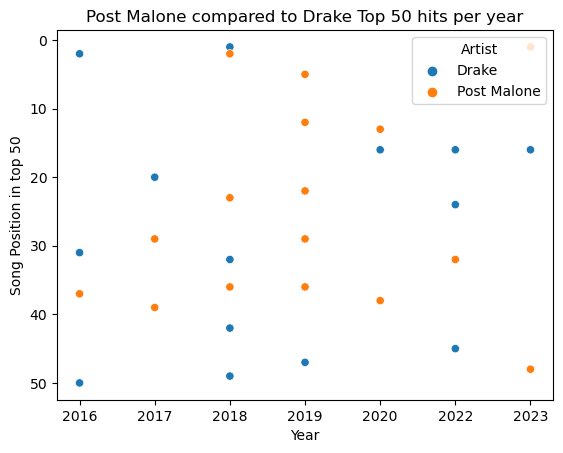

In [13]:
#scatter = post_malone_df.plot.scatter(x='Year', y = 'Song Position in top 50', color = 'green', ylim=(0,50))
scatter = sns.scatterplot(x="Year", y="Song Position in top 50", data=post_malone_df, hue="Artist")
plt.title('Post Malone compared to Drake Top 50 hits per year')
ax = scatter.axes
ax.invert_yaxis()
plt.savefig('Output/fig9')

In [14]:
#ho = popularity of a song is influenced by the release year of the song (reject if p_value < 0.5)
#ha = popularity of a song is not influenced by the release year of the song

In [15]:
#Null hypothesis = Post Malone is in top 10 80% of the time
#popularity of a song is influenced by the release year of the song
top_songs_df.groupby('Year')['Song Popularity'].mean()

Year
2016    80.40
2017    82.68
2018    81.20
2019    82.24
2020    79.94
2022    85.52
2023    90.76
Name: Song Popularity, dtype: float64

In [16]:
song_populatiry_year1 = top_songs_df[top_songs_df['Year'] == '2017']['Song Popularity']
song_populatiry_year2 = top_songs_df[top_songs_df['Year'] == '2023']['Song Popularity']

In [17]:
#there is a asignificant difference in the song popularities by post malone and drake

In [18]:
ttest,pvalue = stats.ttest_ind(song_populatiry_year1, song_populatiry_year2)

In [19]:
pvalue

1.506985830016495e-15

In [20]:
top_songs_df[top_songs_df['Artist']=='Post Malone']['Song Popularity'].mean()

83.5

In [21]:
top_songs_df[top_songs_df['Artist']=='Drake']['Song Popularity'].mean()

81.85714285714286

In [22]:
cat1 = top_songs_df[top_songs_df['Artist']=='Post Malone']
cat2 = top_songs_df[top_songs_df['Artist']=='Drake']

ttest_ind(cat1['Song Popularity'], cat2['Song Popularity'])

Ttest_indResult(statistic=1.0187246757429556, pvalue=0.317055797386026)

In [23]:
top_songs_df.columns

Index(['Year', 'Song Name', 'Artist', 'Artist Popularity', 'Genre', 'Album',
       'Song Popularity', 'Song Position in top 50', 'Duration(min)'],
      dtype='object')

In [24]:
top_songs_2016_df = top_songs_df.loc[top_songs_df['Year'] == '2016']
top_songs_2017_df = top_songs_df.loc[top_songs_df['Year'] == '2017']
top_songs_2018_df = top_songs_df.loc[top_songs_df['Year'] == '2018']
top_songs_2019_df = top_songs_df.loc[top_songs_df['Year'] == '2019']
top_songs_2020_df = top_songs_df.loc[top_songs_df['Year'] == '2020']
top_songs_2021_df = top_songs_df.loc[top_songs_df['Year'] == '2021']
top_songs_2022_df = top_songs_df.loc[top_songs_df['Year'] == '2022']

In [25]:
top_10_songs_df = top_songs_df.loc[top_songs_df['Song Position in top 50'] < 11]
top_10_songs_df

,Year,Song Name,Artist,Artist Popularity,Genre,Album,Song Popularity,Song Position in top 50,Duration(min)
0,2016,Starboy,The Weeknd,97,"canadian contemporary r&b, canadian pop, pop",Starboy,93,1,3.840883
1,2016,One Dance,Drake,97,"canadian hip hop, canadian pop, hip hop, rap, ...",Views,88,2,2.899767
2,2016,Love Yourself,Justin Bieber,90,"canadian pop, pop",Purpose (Deluxe),85,3,3.895333
3,2016,Closer,The Chainsmokers,81,"electropop, pop, tropical house",Closer,86,4,4.082667
4,2016,Hello,Adele,86,"british soul, pop, pop soul, uk pop",25,75,5,4.925033
...,...,...,...,...,...,...,...,...,...
305,2023,Players,Coi Leray,79,"new jersey underground rap, trap queen",Players,93,6,2.326000
306,2023,Die For You - Remix,The Weeknd,97,"canadian contemporary r&b, canadian pop, pop",Die For You (Remix),95,7,3.880950
307,2023,Escapism.,RAYE,80,"uk contemporary r&b, uk pop",My 21st Century Blues,86,8,4.539550
308,2023,Never Felt So Alone,Labrinth,80,"indie poptimism, pop",Never Felt So Alone,86,9,2.669433


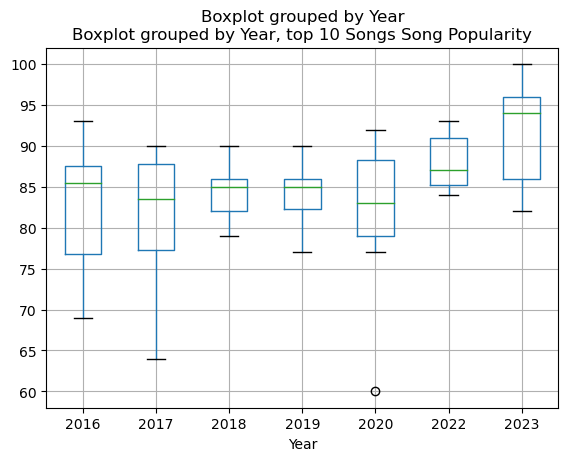

In [26]:
top_10_songs_df.boxplot(by="Year", column="Song Popularity")
plt.title('Boxplot grouped by Year, top 10 Songs Song Popularity')
plt.savefig('Output/fig1')

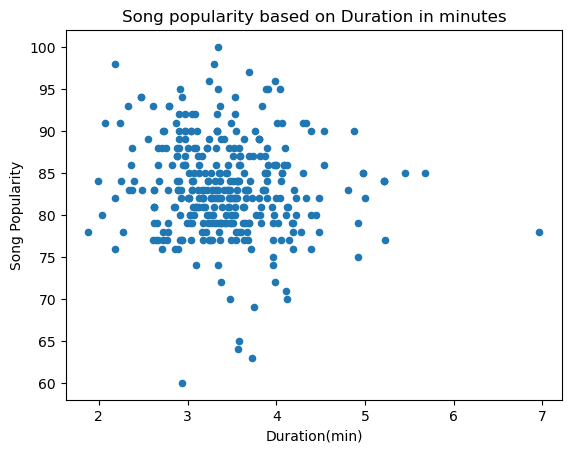

In [27]:
top_songs_df.plot.scatter(x='Duration(min)', y = 'Song Popularity', title='Song popularity based on Duration in minutes')
plt.savefig('Output/fig12')

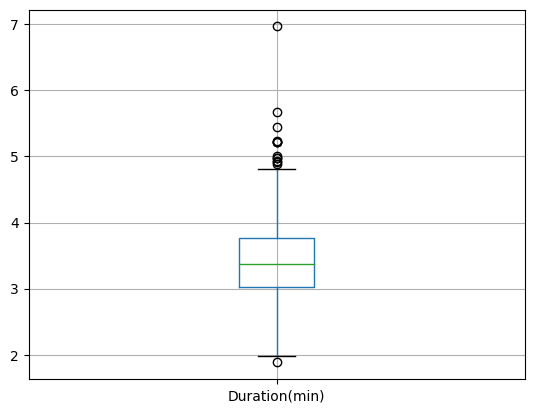

In [28]:
top_songs_df.boxplot(column="Duration(min)")
plt.savefig('Output/fig11')

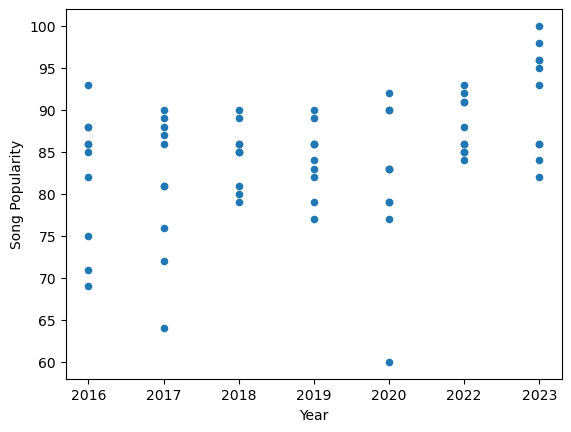

In [29]:
top_10_songs_df.plot.scatter(x='Year', y = 'Song Popularity')
plt.savefig('Output/fig2')

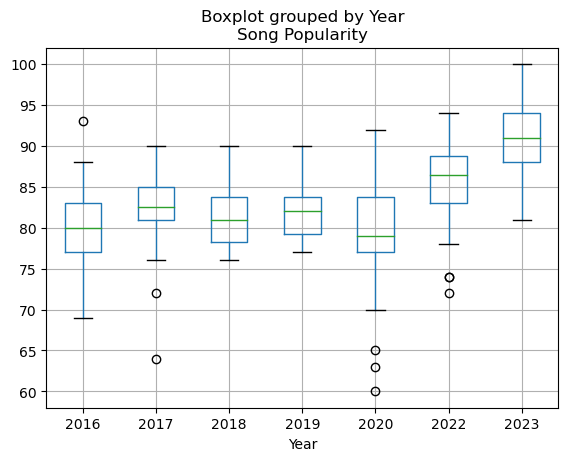

In [30]:
top_songs_df.boxplot(by="Year", column="Song Popularity")
plt.savefig('Output/fig3')

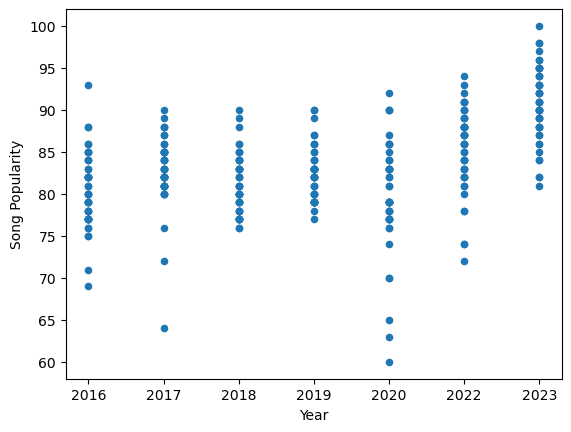

In [31]:
top_songs_df.plot.scatter(x='Year', y = 'Song Popularity')
plt.savefig('Output/fig4')

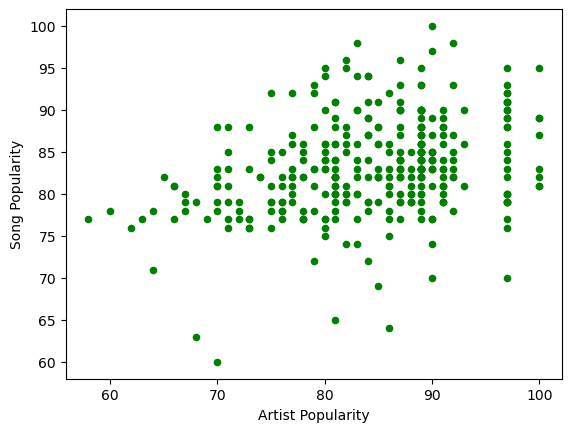

In [32]:
top_songs_df.plot.scatter(x='Artist Popularity', y = 'Song Popularity', color = 'green')
plt.savefig('Output/fig5')

In [33]:
#null hypothesis: Song popularity and Artist Popularity are the same the majority of the time
song_pop_test = top_songs_df['Song Popularity'].mean()
print(song_pop_test)
artist_pop_test =top_songs_df['Artist Popularity'].mean()
print(artist_pop_test)
#ttest,pvalue = stats.ttest_ind(song_pop_test, artist_pop_test)
#pvalue

83.24857142857142
84.38857142857142


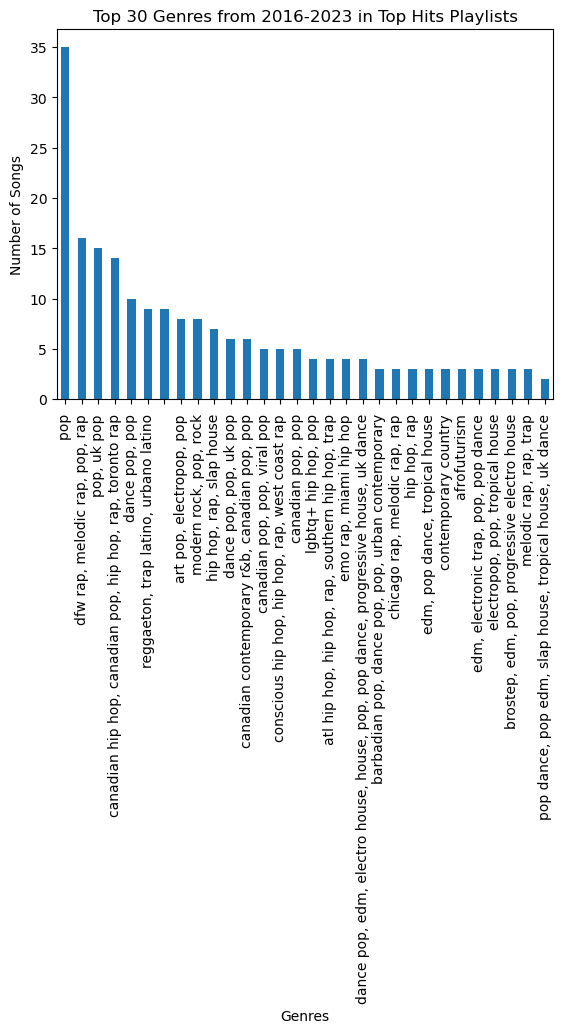

In [34]:
v = top_songs_df['Genre'].value_counts().index
top_genres_df = top_songs_df[top_songs_df['Genre'].isin(top_songs_df['Genre'].value_counts()[top_songs_df['Genre'].value_counts()>1].index)]
#top_genres_df['Genre'].value_counts()
top_genres_df['Genre'].value_counts()[:30].plot(kind='bar')
plt.xlabel('Genres') 
plt.ylabel('Number of Songs')
plt.title('Top 30 Genres from 2016-2023 in Top Hits Playlists')
plt.savefig('Output/fig6')

In [35]:
artistis_frequency_dict = top_songs_df['Artist'].value_counts()
artists_more_than_two = [k for k,v in artistis_frequency_dict.items() if v>1]
artists_more_than_two_df = top_songs_df[top_songs_df['Artist'].isin(artists_more_than_two)]
artists_more_than_two_df

,Year,Song Name,Artist,Artist Popularity,Genre,Album,Song Popularity,Song Position in top 50,Duration(min)
0,2016,Starboy,The Weeknd,97,"canadian contemporary r&b, canadian pop, pop",Starboy,93,1,3.840883
1,2016,One Dance,Drake,97,"canadian hip hop, canadian pop, hip hop, rap, ...",Views,88,2,2.899767
2,2016,Love Yourself,Justin Bieber,90,"canadian pop, pop",Purpose (Deluxe),85,3,3.895333
3,2016,Closer,The Chainsmokers,81,"electropop, pop, tropical house",Closer,86,4,4.082667
6,2016,Pink + White,Frank Ocean,85,"lgbtq+ hip hop, neo soul",Blonde,88,7,3.075267
...,...,...,...,...,...,...,...,...,...
342,2023,Bad Habit,Steve Lacy,82,afrofuturism,Bad Habit,87,43,3.868567
343,2023,Lavender Haze,Taylor Swift,100,pop,Midnights,89,44,3.373250
344,2023,Last Night,Morgan Wallen,93,contemporary country,3 Songs At A Time Sampler,90,45,2.730900
347,2023,I Like You (A Happier Song) (with Doja Cat),Post Malone,89,"dfw rap, melodic rap, pop, rap",Twelve Carat Toothache,88,48,3.214000


In [ ]:
plt.figure(figsize=(30,5))
artists_more_than_two_df['Artist'].value_counts().plot.bar()
plt.xlabel('Artists')
plt.ylabel('Times in Top 50')
plt.title("Artists who appeared in Top 50 Hits more than once from 2016-2023")
plt.savefig('Output/fig7')

In [ ]:
#Top Songs From 2016-2022(Based on popularity greater than 85)
top_popularity_songs_df = (top_songs_df.loc[top_songs_df['Song Popularity'] > 85]).sort_values(by=['Song Popularity'], ascending = False)

top_popularity_songs_df.plot.scatter(x='Song Name', y='Song Popularity', title='Songs with popularity greater than 85(2016-2022 Top Hits)',ylabel='Popularity(Spotify Value)', 
                                 rot=90, ylim=(0,100), figsize=(20,5))
plt.savefig('Output/fig8')


In [ ]:
artist_name = 'Drake'
url = 'https://api.spotify.com/v1/search'
headers = {"Authorization": "Bearer " + token}
query = f"?q={artist_name}&type=artist&limit=1"
query_url = url + query
result = get(query_url, headers=headers)
json_result = json.loads(result.content)
json_result['artists']